In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from Bio.Affy import CelFile
from Bio import Geo
from collections import Counter
from settings import SERIES_FILE, RAW_DF_FILE, RAW_FOLDER

In [2]:
%matplotlib inline

In [3]:
pd.set_option('max_columns', 500)

# RAW

In [4]:
cel_full_paths = list(map(lambda file_name: os.path.join(RAW_FOLDER, file_name), os.listdir(RAW_FOLDER)))
cel_full_paths[0]

'../data/raw/GSM441864.CEL'

In [5]:
example = CelFile.read(open(cel_full_paths[0]))
example.ncols, example.nrows

(712, 712)

In [6]:
example.intensities

array([[   130. ,  16533. ,    148.5, ...,  18519.3,    157. ,  19957. ],
       [ 17015. ,    146. ,  15244.5, ...,    168.5,  18028. ,    166. ],
       [   147.8,  15242.3,    208. , ...,  16889.3,    189.5,  18516.8],
       ..., 
       [ 17824.5,    148.5,  16437.3, ...,    202.8,  17936. ,    187.3],
       [   153. ,  17400. ,    152. , ...,  18478.3,    202. ,  19672. ],
       [ 19682. ,    134. ,  18691. , ...,    197.5,  20193. ,    157. ]])

# Series

In [7]:
def read_series(file_path):
    expression_prefix = 'expression_'
    matrix_mode = False
    
    def process_sample(col_name, values):
        float_char_list = ['event_time']
        col_name = col_name.lower().replace(' ', '_')
        
        if col_name == 'sample_characteristics_ch1':
            col_name = 'characteristic_' + values[0].split(':')[0].strip()
            col_name = col_name.replace(' ', '_')
            values = list(map(lambda value: value.split(':')[1].strip(), values))
            if any(string in col_name for string in float_char_list):
                values = list(map(float, values))
        elif col_name == 'sample_channel_count':
            values = list(map(int, values))
        elif col_name.startswith(expression_prefix):
            values = list(map(float, values))
            
        return col_name, values
    
    df = pd.DataFrame()
    file = open(file_path, 'r')
    
    for row in file:
        col_name, *values = row.strip().split('\t')

        if col_name == '!series_matrix_table_begin':
            matrix_mode = True
            continue
        if col_name == '!series_matrix_table_end':
            matrix_mode = False
            continue
        if col_name.startswith('!Series'):
            continue

        values = list(map(lambda value: value.strip().replace('"', ''), values))
        col_name = col_name.replace('"', '')
        if not matrix_mode:
            if col_name.startswith('!'):
                col_name = col_name.replace('!', '')
            else:
                continue
        elif matrix_mode and col_name != 'ID_REF':
            col_name = expression_prefix + col_name.replace('"', '')
        
        col_name, values = process_sample(col_name, values)
        df[col_name] = values

    return df

In [8]:
df = read_series(SERIES_FILE)
df.head()

sample_title sample_geo_accession          sample_status  \
0  Tissue_BC_Tamoxifen_1070            GSM441624  Public on Aug 13 2010   
1  Tissue_BC_Tamoxifen_1089            GSM441625  Public on Aug 13 2010   
2  Tissue_BC_Tamoxifen_1097            GSM441626  Public on Aug 13 2010   
3  Tissue_BC_Tamoxifen_1103            GSM441627  Public on Aug 13 2010   
4  Tissue_BC_Tamoxifen_1107            GSM441628  Public on Aug 13 2010   

  sample_submission_date sample_last_update_date sample_type  \
0            Aug 18 2009             Sep 06 2013         RNA   
1            Aug 18 2009             Sep 06 2013         RNA   
2            Aug 18 2009             Sep 06 2013         RNA   
3            Aug 18 2009             Sep 06 2013         RNA   
4            Aug 18 2009             Sep 06 2013         RNA   

   sample_channel_count             sample_source_name_ch1  \
0                     1  tissue from breast tumor excision   
1                     1  tissue from breast tumor excision   
2                     1  tissue from breast tumor excision   
3                     1  tissue from breast tumor excision   
4                     1  tissue from breast tumor excision   

  sample_organism_ch1 characteristic_patient_id characteristic_profiling_lab  \
0        Homo sapiens                      1070                          JBI   
1        Homo sapiens                      1089                          JBI   
2        Homo sapiens                      1097                          JBI   
3        Homo sapiens                      1103                          JBI   
4        Homo sapiens                      1107                          JBI   

  characteristic_tissue characteristic_estrogen_receptor_(er)_status  \
0         breast cancer                                          ER+   
1         breast cancer                                          ER+   
2         breast cancer                                          ER+   
3         breast cancer                                          ER+   
4         breast cancer                                          ER+   

  characteristic_endocrine_therapy  \
0  Tamoxifen treatment for 5 years   
1  Tamoxifen treatment for 5 years   
2  Tamoxifen treatment for 5 years   
3  Tamoxifen treatment for 5 years   
4  Tamoxifen treatment for 5 years   

  characteristic_nodal_status_(0=negative,_1=positive,_na=not_applicable)  \
0                                                  0                        
1                                                  0                        
2                                                  0                        
3                                                  0                        
4                                                  0                        

  characteristic_distant_relapse_(1=dr,_0_censored)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 1   
4                                                 1   

   characteristic_event_time_(years) sample_molecule_ch1  \
0                           7.578082           total RNA   
1                           2.676712           total RNA   
2                           7.739726           total RNA   
3                           6.208219           total RNA   
4                           3.717808           total RNA   

                         sample_extract_protocol_ch1 sample_label_ch1  \
0  Total RNA was extracted from fresh frozen tiss...           biotin   
1  Total RNA was extracted from fresh frozen tiss...           biotin   
2  Total RNA was extracted from fresh frozen tiss...           biotin   
3  Total RNA was extracted from fresh frozen tiss...           biotin   
4  Total RNA was extracted from fresh frozen tiss...           biotin   

                           sample_label_protocol_ch1 sample_taxid_ch1

In [9]:
df.to_csv(RAW_DF_FILE, index=False)

In [10]:
df.shape

(298, 22324)

Проблема 1 - мало сэмплов, много фичей

In [11]:
relapse = Counter(df['characteristic_distant_relapse_(1=dr,_0_censored)'])
relapse['1'] / (sum(relapse.values()))

0.23825503355704697

~24% рецидивов (наверное это нормально, но я читал что после химиотерапии 5-10% должно быть)

Проблема 2 - выборка смещена в сторону выздоравливающих

In [12]:
nodal = Counter(df['characteristic_nodal_status_(0=negative,_1=positive,_na=not_applicable)'])
print(nodal['1'] / (sum(relapse.values())), nodal['NA'] / (sum(relapse.values())))

0.37583892617449666 0.03691275167785235


~38% заражения в лимфоузлах, ~4% не извествно

In [13]:
relapsed_nodal = 0
relapsed_not_nodal = 0
for relapse, nodal in zip(df['characteristic_distant_relapse_(1=dr,_0_censored)'],
                        df['characteristic_nodal_status_(0=negative,_1=positive,_na=not_applicable)']):
    if relapse == '1':
            if nodal == '1':
                relapsed_nodal += 1
            elif nodal == '0':
                relapsed_not_nodal += 1

relapsed_nodal / (relapsed_nodal + relapsed_not_nodal)

0.5882352941176471

~59% рецидивов сопровождалось заражением лимфоузлов

In [14]:
set(df['characteristic_estrogen_receptor_(er)_status'])

{'ER+'}

Все злокачественные

# Время

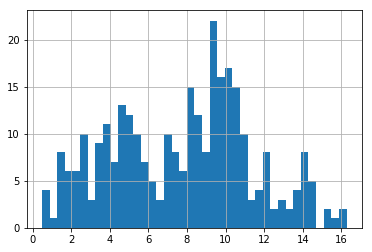

In [15]:
df['characteristic_event_time_(years)'].hist(bins=40)

Выглядит как сумма двух распределений (2 пика). Вероятно, это распределения больных и не больных.

In [16]:
relapsed = []
not_relapsed = []
for relapse, years in zip(df['characteristic_distant_relapse_(1=dr,_0_censored)'],
                          df['characteristic_event_time_(years)']):
    if relapse == '1':
        relapsed.append(years)
    elif relapse == '0':
        not_relapsed.append(years)

relapsed = pd.DataFrame(relapsed)
not_relapsed = pd.DataFrame(not_relapsed)

In [17]:
relapsed.describe()

0
count  71.000000
mean    5.202501
std     3.211105
min     0.498630
25%     2.620548
50%     4.191667
75%     7.354167
max    14.433333

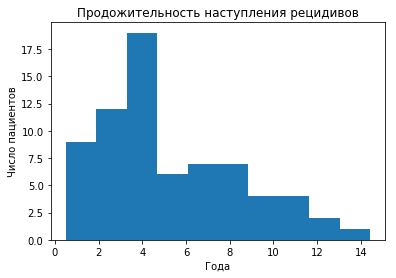

In [18]:
plt.hist(relapsed)
plt.xlabel('Года')
plt.ylabel('Число пациентов')
plt.title('Продожительность наступления рецидивов')

Больше всего рецидивов наступает в районе 4-ого года

In [19]:
not_relapsed.describe()

0
count  227.000000
mean     8.534658
std      3.393713
min      0.500000
25%      5.691781
50%      9.100000
75%     10.475000
max     16.266667

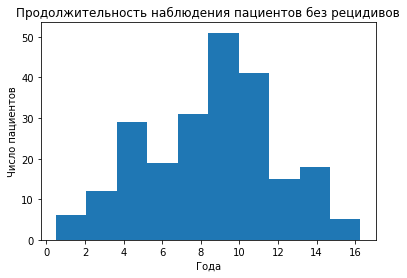

In [20]:
plt.hist(not_relapsed)
plt.xlabel('Года')
plt.ylabel('Число пациентов')
plt.title('Продолжительность наблюдения пациентов без рецидивов')

Люди надлюдаются около 9-10 лет